# Bitcoin Price Prediction 
## Gohur Ali, Matthew Rodriguez

In this notebook we prototype some deep learning models built in PyTorch to discover patterns to aid in the prediction of various trends in Bitcoin. Overall, we hope that it helps us in our personal investments.

We employ the use of multilayer perceptrons for volume and price prediction.

In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')
import requests
import yaml
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import urllib3
import cryptocompare
from datetime import datetime

In [2]:
print("PyTorch version:", torch.__version__)

PyTorch version: 1.0.1.post2


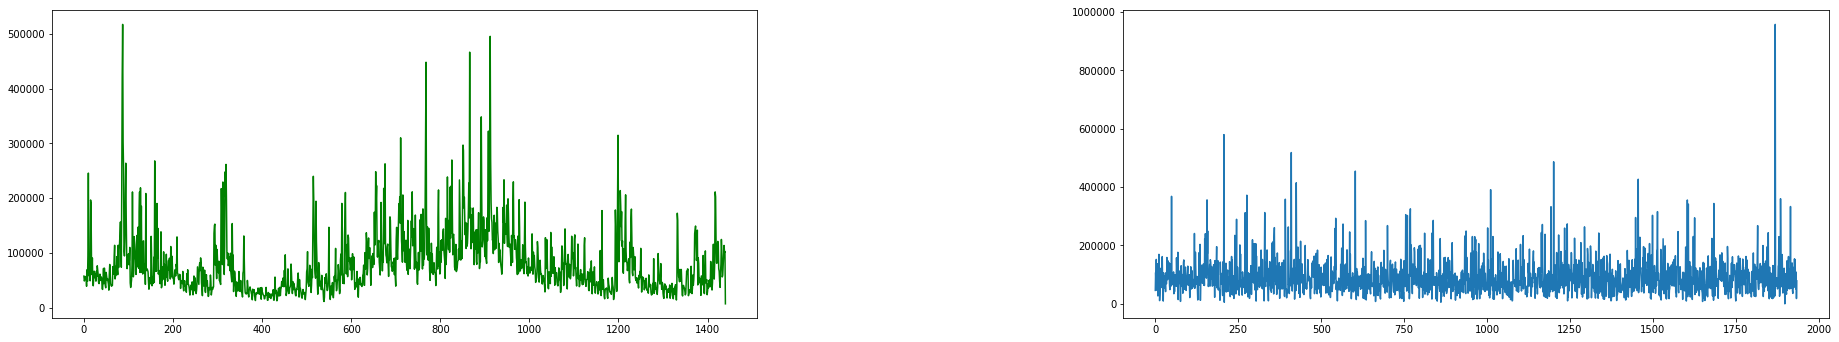

In [44]:
# hourly -- volume -- per day
# USD 

#cryptocompare api key:1 e3c9fe62074dbf5805d45f528d1e60c7ae15be68a63ba57ca3a5f2f9dbbf66f

#close,high,low,open,time,volumefrom,volumeto

def posix2Human(time_):
    timestamp = time_
    dt_object = datetime.fromtimestamp(timestamp)
    return dt_object

histPriceDay = cryptocompare.get_historical_price_day('BTC', curr='USD')
#print((histPriceDay))


# Getting CryptoCompare BTC volume data -- 2000 API calls back 
vol = []
for idx, item in enumerate(histPriceDay['Data']):
    vol.append(item['volumefrom'])    

# -- Init subplots --
f,arr = plt.subplots(1,2)
  
arr[0].plot(np.array(vol),'g')

def fetch_latest_BTC_JSON():
    """Fetch the latest JSON data"""
    API_LINK = 'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol=BTC&market=USD&apikey=SAITMI5ZUMGEKGKY'
    page = requests.get(API_LINK).json()
    return page

page = fetch_latest_BTC_JSON()

vol2 = []
for key,value in page['Time Series (Digital Currency Daily)'].items():
    vol2.append(float(value['5. volume']))
    
arr[1].plot(np.array(vol2))

plt.tight_layout()
f.set_figheight(5)
f.set_figwidth(30)

plt.show()

In [5]:
"""
Basic multilayer perceptron subclass 
of three layers in PyTorch
"""
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(in_features=5,out_features=32)
        self.fc2 = nn.Linear(in_features=32,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=1)
    
    def forward(self, x):
        """"Forward pass definition"""
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x
      
class NumberRegression_MLP(nn.Module):
    def __init__(self):
        super(NumberRegression_MLP,self).__init__()
        self.fc1 = nn.Linear(in_features=1,out_features=32)
        self.fc2 = nn.Linear(in_features=32,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=1)
    def forward(self, x):
        """"Forward pass definition"""
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x
    
class TestRNN(nn.Module):
    def __init__(self):
        pass
    def forward(self,x):
        pass

In [6]:
class TickerData(torch.utils.data.Dataset):
    def __init__(self, table):
        self.dataset = table
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,idx):
        """idx --> data pointer"""
        return self.dataset[idx]

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
def fetch_latest_BTC_JSON():
    """Fetch the latest JSON data"""
    API_LINK = 'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol=BTC&market=USD&apikey=SAITMI5ZUMGEKGKY'
    page = requests.get(API_LINK).json()
    return page
  
def fetch_btc_prices():
    with open("/content/gdrive/My Drive/College/Undergraduate Research/StockData/BTC_data.json") as f:
        return json.load(f)      
      
def parse_alphaV_JSON(raw_data):
    # Remove meta data for now
    raw_data.pop('Meta Data',None)
    # Remove key name
    df = pd.DataFrame.from_dict(raw_data['Time Series (Digital Currency Daily)'],dtype=float)
    # Flip dates as columns into rows
    df = df.transpose()
    return df

def normalize():
    pass
  

def data_split(x_train,y_train):
        x_train, x_test, y_train, y_test = train_test_split(x_train,y_train,test_size=0.2,random_state=100,shuffle=False)
        return x_train, x_test, y_train, y_test

def train(model, x_data,y_data, original_prices):

    prices = torch.tensor(original_prices)
    max_price = torch.max(prices)
    min_price = torch.min(prices)

    print('----Dataset Prep----')
    x_train, x_test, y_train, y_test = data_split(x_data,y_data)
    train_tensorDataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train),torch.from_numpy(y_train))
    train_data_loader = torch.utils.data.DataLoader(
        dataset=train_tensorDataset,
        batch_size=1,
        shuffle=False,
        num_workers=0
    )

    test_tensorDataset = torch.utils.data.TensorDataset(torch.Tensor(x_test),torch.Tensor(y_test))
    test_data_loader = torch.utils.data.DataLoader(
        dataset=test_tensorDataset,
        batch_size=1,
        shuffle=False,
        num_workers=0
    )

    print('-- Model Architecture --')
    print(model)
    
    # -- Model to CUDA GPU --
    #model.to(device)

    # -- Since we are predicting prices --> mean squared error is our loss function
    loss_func = torch.nn.MSELoss()

    # -- Optimizer --> Adam generally works best
    # TODO: choose a better learning rate later
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    total_loss = 0
    losses = []
    for epoch in (range(100)):
        for i, (examples,labels) in tqdm(enumerate(train_data_loader)):

            #print(examples , " ----- " , labels)
            
            optimizer.zero_grad()
            
            # -- Input to CUDA --
            #examples = examples.to(device)
            #labels = labels.to(device)
            
            y_predictions = model(examples.float())
            loss = loss_func(y_predictions.float(),labels.float())

            total_loss += loss.data

            # back-prop to update the weights
            loss.backward()
            # optimizer steps based on lr
            optimizer.step()

            y_preds = y_predictions.cpu().detach().numpy()
            y_preds = torch.tensor(y_preds)
            #print(y_preds.shape)
            test = un_normalize(y_preds, min_price, max_price)
            #print("---> ", test)
            #break

        print ('Epoch [{}/{}], Loss: {}'.format(epoch+1, 100, loss.data))
        #print(list(model.parameters()))
        print("-----------------------------------------------------------------------------")
        losses.append(loss.data)
    return losses, test_data_loader, loss_func, model, min_price, max_price, y_test


def table_edit(dataframe):
    dataframe = dataframe.drop(labels=['1b. open (USD)','2b. high (USD)','3b. low (USD)','4b. close (USD)'],axis=1)
    table_col_order = ['1a. open (USD)','2a. high (USD)','3a. low (USD)','5. volume','6. market cap (USD)','4a. close (USD)']
    dataframe = dataframe[table_col_order]
    return dataframe

def loss_visualize(loss_tensor):
    losses = np.array(loss_tensor)
    print(losses)
    
    plt.plot(losses)
    
def validation_test(test_dataloader, criterion, model, norm_min, norm_max):
    test_loss = 0
    accuracy = 0
    all_predictions = []
    for (examples, labels) in test_dataloader:
        output = model.forward(examples)
        
        un_normed_outputs = un_normalize(output, norm_min,norm_max)
        all_predictions.append(un_normed_outputs.detach())
        #print("output --> ", un_normed_outputs)
        loss = criterion(output, labels).item()
        test_loss += loss
        
        #ps = torch.exp(output)
        #equality = (labels.data == ps.max(dim=1)[1])
        #accuracy += equality.type(torch.FloatTensor).mean()
        
        #print('output --> ', un_normed_outputs, ' loss --> ', loss)
        
    return test_loss, accuracy, all_predictions

def un_normalize(norm_val,min_val,max_val,typelist=None):
    if(typelist):
        for idx,item in enumerate(norm_val):
            new_val = item * (max_val - min_val) + min_val
            norm_val[idx] = new_val
        return norm_val
    else:
        return norm_val * (max_val - min_val) + min_val  

def prediction_visualization(minimum_price,maximum_price,close_prices,model_predictions):
      test_values = np.array(un_normalize(norm_val=close_prices,min_val=minimum_price,max_val=maximum_price,typelist=True))
      #print(np.array(model_predictions.grad))
      #model_predictions[0].requires_grad = False
      for idx,item in enumerate(model_predictions):
          model_predictions[idx] = np.asscalar(item.numpy())
      predicted_values = model_predictions
      
      print(len(test_values))
      print(len(predicted_values))
      
      plt.plot(np.array(test_values))
      plt.plot(np.array(predicted_values))
      plt.show()
      pass
    
def volume_visualization(volume):
      vol = np.array(volume)
      plt.plot(vol)
      pass
    
def VMA_calculation(prices=[]):
    prices = np.array(prices)
      
    n_prices = []
    for idx, p in enumerate(prices):
        if(idx + 1 == len(prices)):
            break
        p1 = prices[idx]
        p2 = prices[idx+1]
        arr = np.array([p1,p2])#,p3,p4,p5,p6,p7,p8,p9,p10,p11])
        n_prices.append(arr)

    vmas = []
    for arr in n_prices:
        sum_vol = arr.sum()
        vmas.append(sum_vol/2)
    
    first_ten = vmas[:10]
    average_num = np.average(first_ten)
    vmas = np.insert(vmas,0,average_num)
    
    #plt.figure(figsize=(20,10))
    #plt.plot(np.array(prices))
    #plt.plot(np.array(vmas))
    return vmas


def vol_dataset_prep(vma,volume,original_volume):
    """VMA - x_train -- volume -- y_train"""
    print(len(vma))
    print(len(volume))
    print(len(original_volume))
    
#     vma = torch.tensor(vma)
#     volume = torch.tensor(volume)
    
    
    #########################
    x_train,x_test,y_train,y_test = data_split(volume,volume)
    
    #######################
    
    #x_train,x_test,y_train,y_test = data_split(vma,volume)
    
    train_data = torch.utils.data.TensorDataset(torch.from_numpy(x_train),torch.from_numpy(y_train))
    test_data = torch.utils.data.TensorDataset(torch.from_numpy(x_test),torch.from_numpy(y_test))
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_data,
        batch_size=1,
        shuffle=False,
        num_workers=0
    )
    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_data,
        batch_size=1,
        shuffle=False,
        num_workers=0
    )
    return x_train,y_train,x_test,y_test,train_dataloader,test_dataloader

def vol_train(model, train_dataloader):
    loss_func = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    
    total_loss = 0
    losses = []
    for epoch in (range(10)):
        for i, (examples,labels) in tqdm(enumerate(train_dataloader)):

            optimizer.zero_grad()
            
            y_predictions = model(examples.float())
            loss = loss_func(y_predictions.float(),labels.float())

            total_loss += loss.data

            # back-prop to update the weights
            loss.backward()
            # optimizer steps based on lr
            optimizer.step()

            y_preds = y_predictions.cpu().detach().numpy()
            y_preds = torch.tensor(y_preds)
            #print(y_preds.shape)
            #print("---> ", test)
            #break

        print ('Epoch [{}/{}], Loss: {}'.format(epoch+1, 100, loss.data))
        #print(list(model.parameters()))
        print("-----------------------------------------------------------------------------")
        losses.append(loss.data)
    return model,loss_func,total_loss,losses

def vol_test(model,criterion,test_dataloader,min_val,max_val):
    test_loss = 0
    accuracy = 0
    all_predictions = []
    for (examples, labels) in test_dataloader:
        output = model.forward(examples.float())
        un_normed_outputs = un_normalize(output, min_val,max_val)
        all_predictions.append(un_normed_outputs.detach())
        loss = criterion(output, labels.float()).item()
        test_loss += loss
    return test_loss, accuracy, all_predictions

def vol_prediction_visualization(predictions,actual,min_val,max_val):
    for idx,item in enumerate(predictions):
          predictions[idx] = np.asscalar(item.numpy())
    print(predictions)
    actual = un_normalize(actual,min_val,max_val,typelist=True)
    print(actual)
    plt.figure(figsize=(20,10))
    plt.plot(np.array(actual),color='g')
    plt.plot(np.array(predictions),color='#FFA500')
      

29it [00:00, 287.54it/s]

[ 9667.40442881  9464.30110037 10892.855597   ...   446.81975514
   438.37782382   479.0234337 ]
113.97640361
957152.47872048
1934
1934
1934


1547it [00:04, 335.68it/s]
23it [00:00, 227.16it/s]

Epoch [1/100], Loss: 1.2401081050938956e-07
-----------------------------------------------------------------------------


1547it [00:05, 289.01it/s]
19it [00:00, 181.89it/s]

Epoch [2/100], Loss: 6.097975457919347e-09
-----------------------------------------------------------------------------


1547it [00:05, 291.43it/s]
38it [00:00, 376.85it/s]

Epoch [3/100], Loss: 1.1235875341242263e-08
-----------------------------------------------------------------------------


1547it [00:07, 198.48it/s]
34it [00:00, 328.30it/s]

Epoch [4/100], Loss: 4.5798202336300164e-05
-----------------------------------------------------------------------------


1547it [00:05, 272.73it/s]
41it [00:00, 409.74it/s]

Epoch [5/100], Loss: 1.2367244153210777e-06
-----------------------------------------------------------------------------


1547it [00:03, 421.27it/s]
40it [00:00, 393.50it/s]

Epoch [6/100], Loss: 9.06966931779607e-07
-----------------------------------------------------------------------------


1547it [00:03, 406.67it/s]
45it [00:00, 448.84it/s]

Epoch [7/100], Loss: 1.263728250933127e-07
-----------------------------------------------------------------------------


1547it [00:03, 414.87it/s]
33it [00:00, 323.96it/s]

Epoch [8/100], Loss: 2.98719356806032e-07
-----------------------------------------------------------------------------


1547it [00:03, 396.91it/s]
31it [00:00, 307.49it/s]

Epoch [9/100], Loss: 1.679419983702246e-05
-----------------------------------------------------------------------------


1547it [00:04, 353.29it/s]


Epoch [10/100], Loss: 5.6928715963522336e-08
-----------------------------------------------------------------------------
[93896.734375, 97913.953125, 72859.640625, 61525.30859375, 52656.625, 84362.4140625, 101066.90625, 92404.375, 135471.21875, 131316.328125, 46487.32421875, 62133.203125, 112309.9296875, 78512.6328125, 113370.7734375, 64596.98046875, 73705.1328125, 68673.0546875, 44257.5390625, 84304.546875, 97643.3359375, 83594.6640625, 85221.078125, 94158.9765625, 90251.296875, 63625.9140625, 72911.9140625, 103811.890625, 143648.953125, 169039.6875, 89269.765625, 67238.296875, 63809.01953125, 72011.4765625, 206447.59375, 225797.484375, 77704.296875, 76596.6640625, 41855.28125, 82006.40625, 113783.046875, 80698.75, 84367.1484375, 183646.734375, 167712.40625, 55325.859375, 64265.03515625, 107234.640625, 145925.203125, 151073.625, 182331.890625, 152640.546875, 97982.9609375, 55933.6640625, 184315.703125, 61220.09375, 52151.1015625, 64586.3125, 74420.7578125, 82899.9296875, 54118.24218

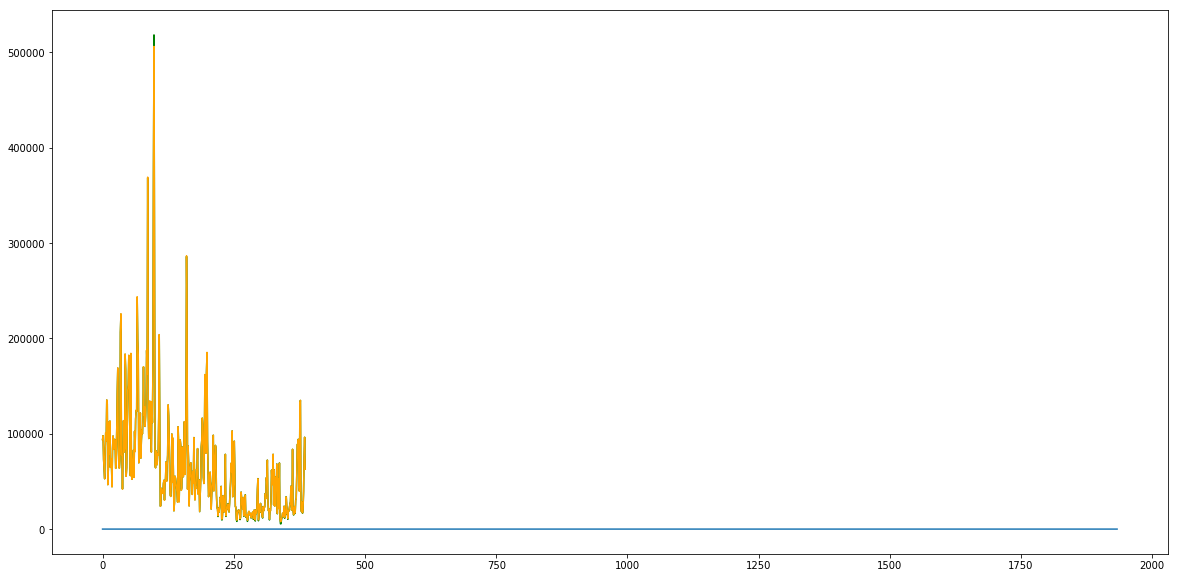

In [17]:
def main():    
    # ------------------------------------------ PREPROCESSING ----------------------------------------------
    raw_price_data = fetch_latest_BTC_JSON()
#     raw_price_data = fetch_btc_prices()
    data_df = parse_alphaV_JSON(raw_data=raw_price_data)
    data_df = data_df.iloc[::-1]
    
    prices = np.array(data_df['4a. close (USD)'].tolist())
    print(prices)
    
    original_volume = data_df['5. volume'].values
    min_volume = np.min(data_df['5. volume'].values)
    max_volume = np.max(data_df['5. volume'].values)
    print(min_volume)
    print(max_volume)
    
    # -- Normalize the Data --
    min_max_scaler = preprocessing.MinMaxScaler()
    data_df = pd.DataFrame(min_max_scaler.fit_transform(data_df), columns=data_df.columns)
    # print(data_df)
    data_df = table_edit(data_df)
    y_train = np.array(data_df['4a. close (USD)'].tolist())
    data_df = data_df.drop(labels=['4a. close (USD)'],axis=1)

    vmas = VMA_calculation(prices=data_df['5. volume'].values)
    
    #print(vmas)
    #print(un_normalize(norm_val=vmas,min_val=min_volume,max_val=max_volume,typelist=True))
    
    x_train,y_train,x_test,y_test,train_dataloader,test_dataloader = vol_dataset_prep(vmas,data_df['5. volume'].values,original_volume)
    vol_predictor = NumberRegression_MLP()
    model,loss_func,_,_ = vol_train(vol_predictor, train_dataloader)
    test_loss,accuracy,predictions = vol_test(vol_predictor,loss_func,test_dataloader,min_volume,max_volume)
    vol_prediction_visualization(predictions,y_test,min_volume,max_volume)
    #print(data_df)
    test = data_df['5. volume'].values
    print(test)
    volume_visualization(test)
    
    
#     model = MLP()
#     losses, test_data_loader, loss_func, model, min_price, max_price, test_prices = train(model, data_df.values,y_train,prices)
#     loss_visualize(losses)
#     _, _, all_unnormed_outputs = validation_test(test_dataloader=test_data_loader,criterion=loss_func, model=model, norm_min=min_price, norm_max=max_price)
    
#     prediction_visualization(minimum_price=min_price,maximum_price=max_price,close_prices=test_prices,model_predictions=all_unnormed_outputs)

main()